In [2]:
!pip install anytree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.3 MB/s eta 0:00:00


In [1]:
!pip install pandas numpy typing

In [1]:
import pandas as pd
import math
from collections import Counter
from anytree import NodeMixin, RenderTree
from typing import Dict, List
from anytree import RenderTree
from graphviz import Digraph
from graphviz import Source

In [2]:
class DecTree():

    def __init__(self, data: pd.DataFrame, target_attribute: str):
        self.data = data
        self.target_attr = target_attribute
        self.target_attr_vals = data[target_attribute].unique()
        self.root_node = None

    def pmf_target(self, df: pd.DataFrame) -> Dict[str, float]:
        target_counts = df[self.target_attr].value_counts(normalize=True)
        return dict(target_counts)

    def entropy(self, pmf: Dict[str, float]) -> float:
        entropy_val = -sum(p * math.log2(p) for p in pmf.values())
        return entropy_val

    def cal_entropy_df(self, df: pd.DataFrame) -> float:
        pmf = self.pmf_target(df)
        entropy_val = self.entropy(pmf)
        return entropy_val

    def info_gain_attribute(self, df: pd.DataFrame, attribute: str) -> float:
        total_entropy = self.cal_entropy_df(df)
        attribute_groups = df.groupby(attribute)
        weighted_entropy = sum(len(subgroup) / len(df) * self.cal_entropy_df(subgroup) for _, subgroup in attribute_groups)
        information_gain = total_entropy - weighted_entropy
        return information_gain

    def max_info_gain_attribute(self, df: pd.DataFrame, attributes: List[int]) -> str:
        info_gain_dict = {attr: self.info_gain_attribute(df, attr) for attr in attributes}
        max_attr = max(info_gain_dict, key=info_gain_dict.get)
        print("max_info_gain_attribute = ", max_attr, "INFG-Value = ", info_gain_dict[max_attr])
        return max_attr

    def build_tree_infgain(self, df: pd.DataFrame, attr_list: List[str], start_node: 'DecTreeNode'):

      if len(df[self.target_attr].unique()) == 1:
          start_node.name = df[self.target_attr].iloc[0]
          return

      if not attr_list:
          start_node.name = df[self.target_attr].value_counts().idxmax()
          return

      max_attr = self.max_info_gain_attribute(df, attr_list)
      start_node.attribute = max_attr

      remaining_attrs = [attr for attr in attr_list if attr != max_attr]  # Exclude the selected attribute
      for value in df[max_attr].unique():
        value_subset = df[df[max_attr] == value]
        if value_subset.empty:
            leaf_node = DecTreeNode(name=df[self.target_attr].mode().values[0], attribute=max_attr, parent=start_node)
        else:
            child_node = DecTreeNode(name=value, attribute=max_attr, parent=start_node)
            self.build_tree_infgain(value_subset, attr_list[:], child_node)

    def generate_tree(self):
        attributes = self.data.columns.to_list()
        attributes.remove(self.target_attr)

        start_node = DecTreeNode("start", "start")
        self.build_tree_infgain(self.data, attributes, start_node)

        self.root_node = start_node

    def print_tree(self):
        for pre, _, node in RenderTree(self.root_node):
            print(f"{pre} {node.attribute}={node.name}")


    def predict(self, X: pd.DataFrame) -> List[str]:
        predictions = []
        for _, row in X.iterrows():
            node = self.root_node
            while node.children:
                attr_value = row[node.attribute.split('=')[0]]
                next_child = next((child for child in node.children if child.name == attr_value), None)
                if next_child:
                    node = next_child
                else:
                    break
            predictions.append(node.name)
        return predictions


class DecTreeNode(NodeMixin):
    def __init__(self, name: str, attribute: str, parent: 'DecTreeNode' = None):
        super(DecTreeNode, self).__init__()
        self.name = name
        self.attribute = attribute
        self.parent = parent
        self.attr_value = f"{attribute}={name}"


In [3]:
!pwd

/content


In [4]:
data  = pd.read_csv("data.csv")
data

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


max_info_gain_attribute =  outlook INFG-Value =  0.24674981977443933
max_info_gain_attribute =  humidity INFG-Value =  0.9709505944546686
max_info_gain_attribute =  windy INFG-Value =  0.9709505944546686
 outlook=start
├──  humidity=sunny
│   ├──  humidity=no
│   └──  humidity=yes
├──  outlook=yes
└──  windy=rainy
    ├──  windy=yes
    └──  windy=no


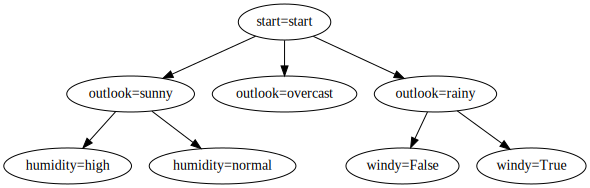

In [5]:
tree = DecTree(data, 'play')
tree.generate_tree()
tree.print_tree()


dot = Digraph()
for pre, _, node in RenderTree(tree.root_node):
    dot.node(node.attr_value)
    if node.parent:
        dot.edge(node.parent.attr_value, node.attr_value)
dot.render("decision_tree_visualization", format="png", view=True)
Source(dot.source)

In [6]:
dt_train = pd.read_csv("cars_train.csv")
dt_test = pd.read_csv("cars_test.csv")

dt_test.head()

,buying_price,maintenance_cost,num_doors,num_persons,size_luggage,safety,decision
0,vhigh,med,2,2,small,low,unacc
1,high,high,3,4,big,med,acc
2,low,med,4,2,big,low,unacc
3,vhigh,high,5more,4,small,low,unacc
4,med,med,4,2,med,high,unacc


In [7]:
# Train
dec_tree = DecTree(dt_train, "decision")
dec_tree.generate_tree()
dec_tree.print_tree()

max_info_gain_attribute =  safety INFG-Value =  0.18923379102137117
max_info_gain_attribute =  num_persons INFG-Value =  0.4396892296875916
max_info_gain_attribute =  maintenance_cost INFG-Value =  0.17299697177164308
max_info_gain_attribute =  buying_price INFG-Value =  0.7960650668536479
max_info_gain_attribute =  num_doors INFG-Value =  0.6500224216483541
max_info_gain_attribute =  num_doors INFG-Value =  0.4464393446710155
max_info_gain_attribute =  size_luggage INFG-Value =  0.9182958340544896
max_info_gain_attribute =  buying_price INFG-Value =  0.4394969869215134
max_info_gain_attribute =  buying_price INFG-Value =  0.6500224216483541
max_info_gain_attribute =  maintenance_cost INFG-Value =  0.19861454887121555
max_info_gain_attribute =  buying_price INFG-Value =  0.9852281360342515
max_info_gain_attribute =  buying_price INFG-Value =  0.9402859586706311
max_info_gain_attribute =  num_persons INFG-Value =  0.25616728268592137
max_info_gain_attribute =  maintenance_cost INFG-Valu

In [8]:
# Test
dt_test_x = dt_test.drop(columns="decision")
dt_test_y = dt_test["decision"].to_list()

preds = dec_tree .predict(dt_test_x)

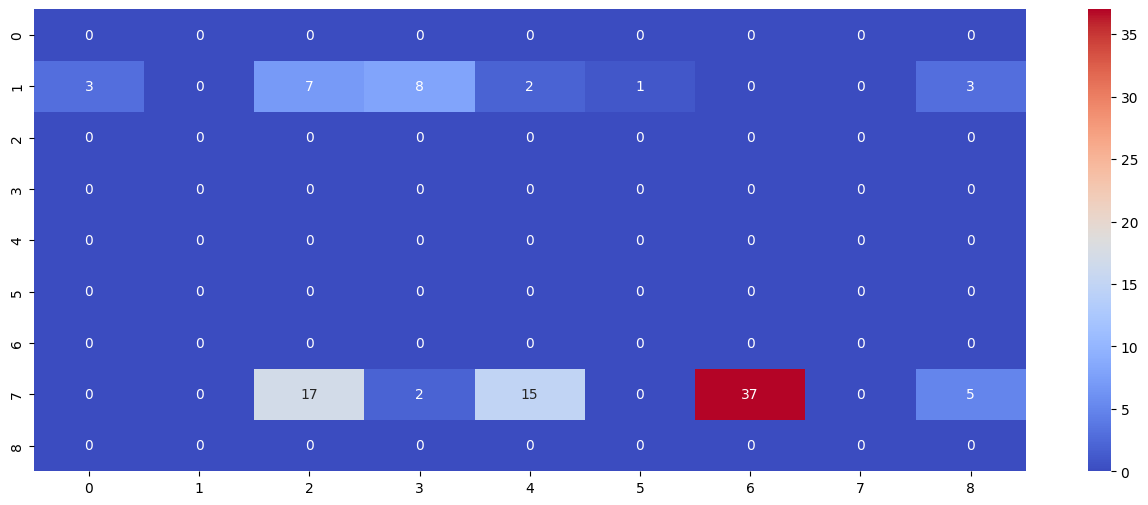

In [9]:
# Evaluate results
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns

acc = accuracy_score(dt_test_y, preds)
cm = confusion_matrix(dt_test_y, preds)
# print(f"Accuracy: {acc}")
# print(cm)

plt.figure(figsize=(16, 6))
fig8= sns.heatmap(cm, annot=True, cmap='coolwarm')
fig8.figure.savefig('Confusion_Metrix.png',  bbox_inches='tight')

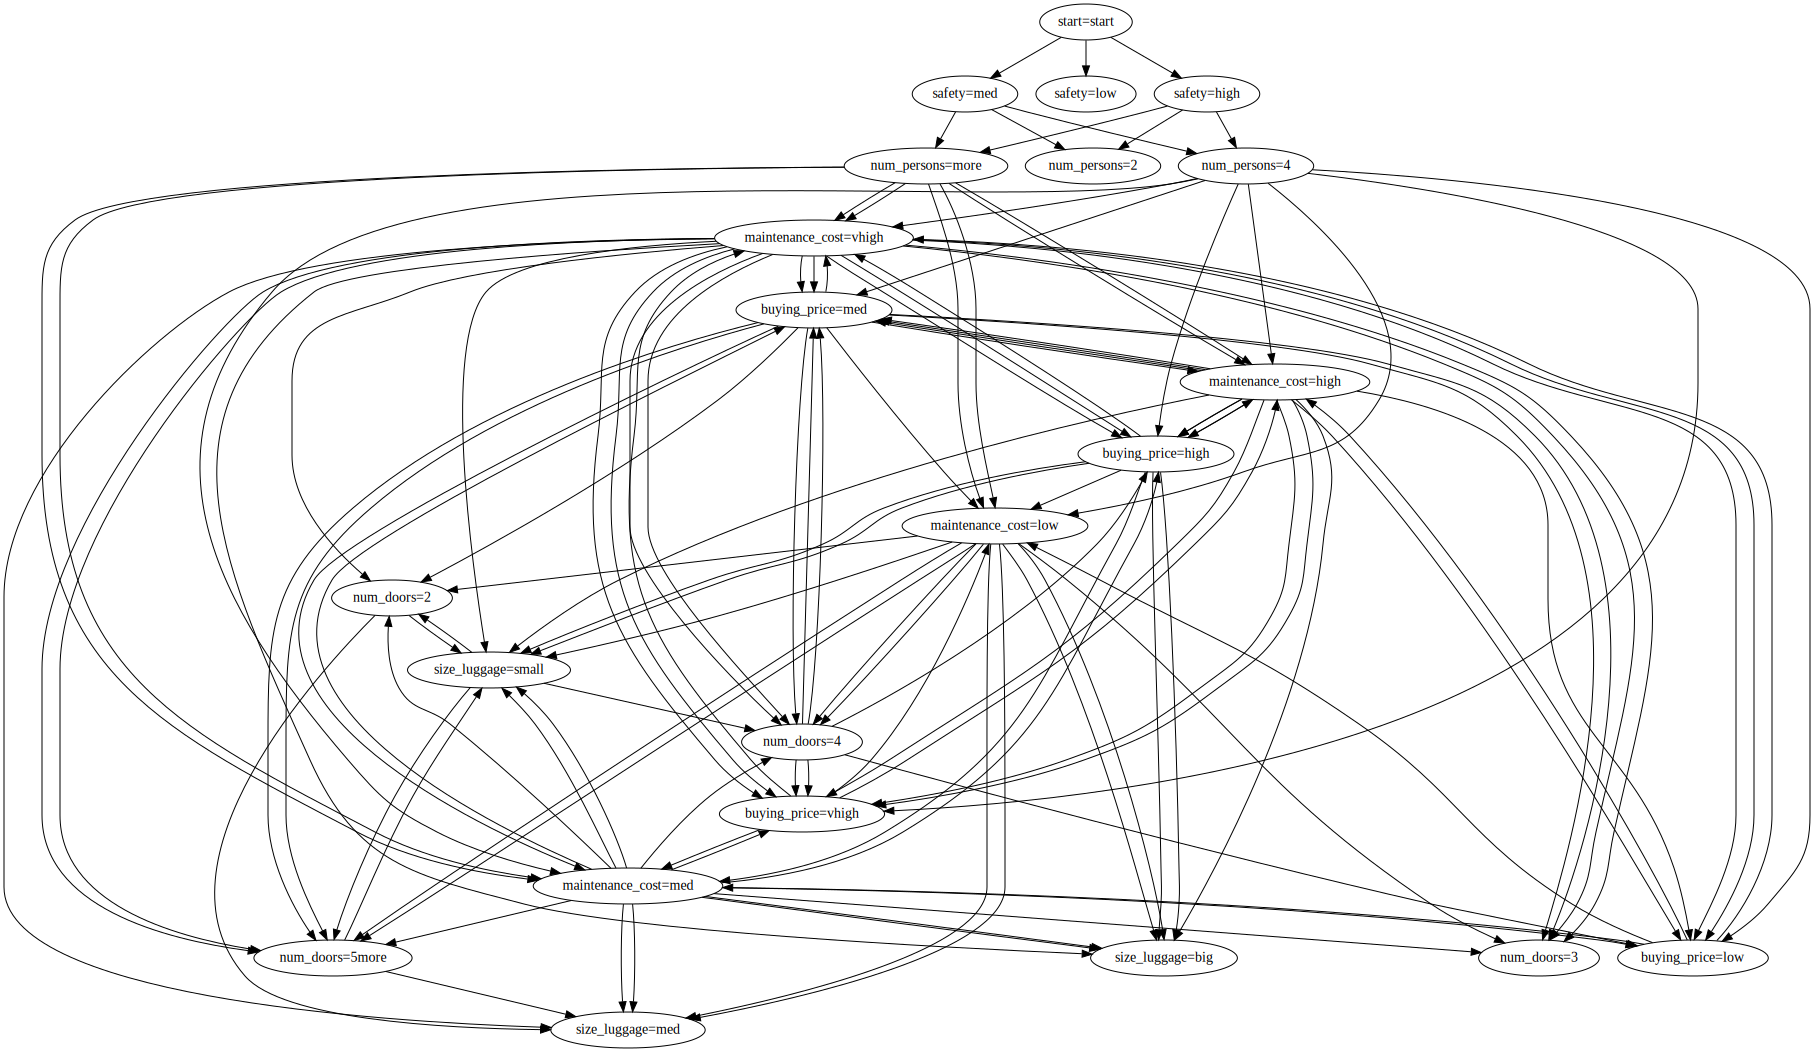

In [16]:
# Create a graphviz Digraph object
dot = Digraph()

# Add nodes and edges to the graphviz object based on your tree structure
for pre, _, node in RenderTree(dec_tree.root_node):
    dot.node(node.attr_value)

    if node.parent:
        dot.edge(node.parent.attr_value, node.attr_value)

# Visualize the decision tree
dot.render("decision_tree_visualization", format="png", view=True)
Source(dot.source)